In [1]:
import logging
import sys


date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

# Data

### Training data
- Source: http://mattmahoney.net/dc/text8.zip
- Stored in: `data/train.txt`

### Analogies data
- Source: https://raw.githubusercontent.com/nicholas-leonard/word2vec/refs/heads/master/questions-words.txt
- Stored in: `data/analogies.txt`

# Defining model

In [2]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models.word2vec import Text8Corpus


class EpochLogger(CallbackAny2Vec):
    def __init__(self):
        self.epoch = 0
        self.last_logged_loss = 0
        self.loss_curve = []

    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")

    def on_epoch_end(self, model):
        curr_loss = model.get_latest_training_loss() - self.last_logged_loss
        self.last_logged_loss = model.get_latest_training_loss()

        self.loss_curve.append(curr_loss)

        print(
            f"Epoch #{self.epoch} end.\nTraining loss: {curr_loss}"
        )
        self.epoch += 1


epoch_logger = EpochLogger()

word_embedder = Word2Vec(
    sentences=Text8Corpus(fname="../data/train.txt"),
    sg=0,
    window=15,
    vector_size=20,
    epochs=50,
    compute_loss=True,
    callbacks=[epoch_logger],
    min_count=0,
    workers=4,
)


2024-12-24 15:03:54 collecting all words and their counts
2024-12-24 15:03:54 PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2024-12-24 15:04:02 collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2024-12-24 15:04:02 Creating a fresh vocabulary
2024-12-24 15:04:03 Word2Vec lifecycle event {'msg': 'effective_min_count=0 retains 253854 unique words (100.00% of original 253854, drops 0)', 'datetime': '2024-12-01T15:04:03.576788', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x86_64-with-glibc2.35', 'event': 'prepare_vocab'}
2024-12-24 15:04:03 Word2Vec lifecycle event {'msg': 'effective_min_count=0 leaves 17005207 word corpus (100.00% of original 17005207, drops 0)', 'datetime': '2024-12-01T15:04:03.578193', 'gensim': '4.3.3', 'python': '3.10.14 (main, Apr 15 2024, 18:28:39) [Clang 17.0.6 ]', 'platform': 'Linux-5.15.153.1-microsoft-standard-WSL2-x

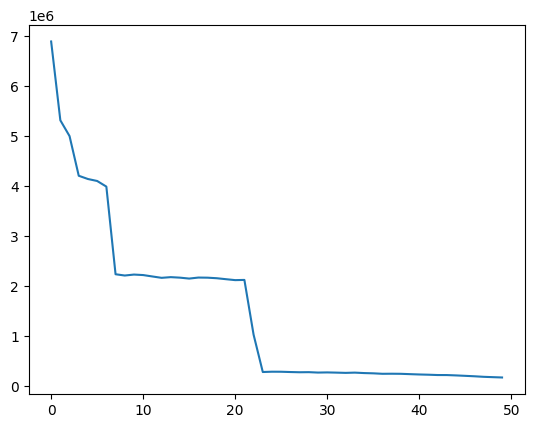

In [3]:
import matplotlib.pyplot as plt

plt.plot(epoch_logger.loss_curve)
plt.show()

In [4]:
word_embedder.wv.evaluate_word_analogies("../data/analogies.txt")

2024-12-24 15:28:29 Evaluating word analogies for top 300000 words in the model on ../data/analogies.txt
2024-12-24 15:28:34 capital-common-countries: 11.9% (60/506)
2024-12-24 15:29:11 capital-world: 3.6% (151/4216)
2024-12-24 15:29:20 currency: 0.7% (6/866)
2024-12-24 15:29:45 city-in-state: 1.5% (37/2467)
2024-12-24 15:29:51 family: 16.6% (84/506)
2024-12-24 15:30:03 gram1-adjective-to-adverb: 2.9% (29/992)
2024-12-24 15:30:16 gram2-opposite: 3.3% (27/812)
2024-12-24 15:30:39 gram3-comparative: 19.4% (258/1332)
2024-12-24 15:30:52 gram4-superlative: 2.4% (24/992)
2024-12-24 15:31:06 gram5-present-participle: 8.8% (93/1056)
2024-12-24 15:31:33 gram6-nationality-adjective: 25.9% (414/1599)
2024-12-24 15:32:03 gram7-past-tense: 9.7% (152/1560)
2024-12-24 15:32:29 gram8-plural: 12.8% (170/1332)
2024-12-24 15:32:45 gram9-plural-verbs: 5.6% (49/870)
2024-12-24 15:32:45 Quadruplets with out-of-vocabulary words: 2.2%
2024-12-24 15:32:45 NB: analogies containing OOV words were skipped from e

(0.08133570606092327,
 [{'section': 'capital-common-countries',
   'correct': [('ATHENS', 'GREECE', 'BERLIN', 'GERMANY'),
    ('ATHENS', 'GREECE', 'HAVANA', 'CUBA'),
    ('ATHENS', 'GREECE', 'PARIS', 'FRANCE'),
    ('ATHENS', 'GREECE', 'TEHRAN', 'IRAN'),
    ('BAGHDAD', 'IRAQ', 'HAVANA', 'CUBA'),
    ('BANGKOK', 'THAILAND', 'BEIJING', 'CHINA'),
    ('BANGKOK', 'THAILAND', 'HELSINKI', 'FINLAND'),
    ('BEIJING', 'CHINA', 'BERLIN', 'GERMANY'),
    ('BEIJING', 'CHINA', 'CAIRO', 'EGYPT'),
    ('BEIJING', 'CHINA', 'HAVANA', 'CUBA'),
    ('BEIJING', 'CHINA', 'MOSCOW', 'RUSSIA'),
    ('BERLIN', 'GERMANY', 'HAVANA', 'CUBA'),
    ('BERLIN', 'GERMANY', 'HELSINKI', 'FINLAND'),
    ('BERLIN', 'GERMANY', 'LONDON', 'ENGLAND'),
    ('BERLIN', 'GERMANY', 'MOSCOW', 'RUSSIA'),
    ('BERLIN', 'GERMANY', 'PARIS', 'FRANCE'),
    ('BERLIN', 'GERMANY', 'STOCKHOLM', 'SWEDEN'),
    ('BERLIN', 'GERMANY', 'TOKYO', 'JAPAN'),
    ('BERLIN', 'GERMANY', 'ATHENS', 'GREECE'),
    ('BERLIN', 'GERMANY', 'BEIJING', 'CHIN